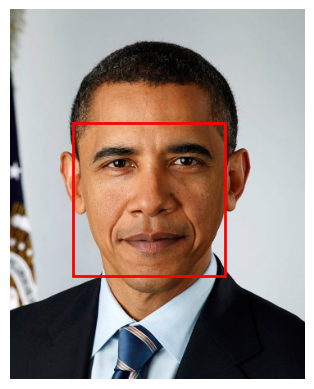

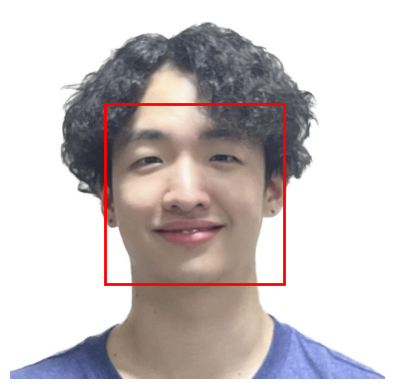

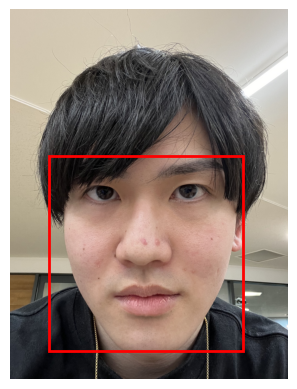

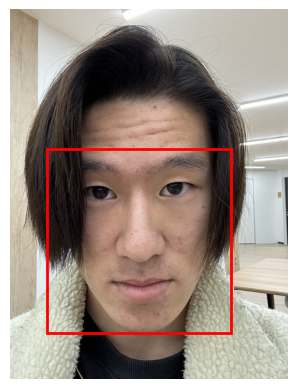

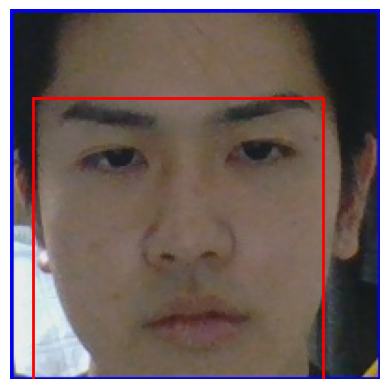

[0.76129499 0.47540173 0.40955351 0.5721929 ]
[False, False, False, False]
最も類似している顔の画像名: hhth22170005.png


In [2]:
import face_recognition
import matplotlib.pyplot as plt
import cv2
import openpyxl
from datetime import datetime

face_cascade_path = 'haarcascade_frontalface_alt.xml'

# 顔検出器の読み込み
face_cascade = cv2.CascadeClassifier(face_cascade_path)
# カメラを起動
cap = cv2.VideoCapture(0)

while True:
    # カメラからフレームをキャプチャ
    ret, frame = cap.read()
    
    # 顔検出を実行
    faces = face_cascade.detectMultiScale(frame, scaleFactor=1.1, minNeighbors=5, minSize=(50, 50))
    
    # 顔の領域を矩形で囲む
    for (x, y, w, h) in faces:
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
        face = frame[y:y+h, x:x+w]  # 顔の部分を切り出す
        # 顔画像をファイルに保存
        cv2.imwrite('detected_face.jpg', face)
    
    # フレームを表示
    cv2.imshow('Face Detection', frame)
    
    # 'q'キーでループを抜ける
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# カメラをリリースし、ウィンドウを閉じる
cap.release()
cv2.destroyAllWindows()

# 顔画像リスト
facelist = ["known-face_01.png", "hhth22170037.jpg", "hhth22170005.png","hhth22170024.png"]

# 保存されている人物の顔の画像を読み込む。
known_face_imgs = []
for path in facelist:
    img = face_recognition.load_image_file(path)
    known_face_imgs.append(img)

# 認証する人物の顔の画像を読み込む。
face_img_to_check = face_recognition.load_image_file("detected_face.jpg")

# 顔の画像から顔の領域を検出する。
known_face_locs = []
for img in known_face_imgs:
    loc = face_recognition.face_locations(img, model="hog")
    known_face_locs.append(loc)

face_loc_to_check = face_recognition.face_locations(face_img_to_check, model="hog")


# 検出した顔の位置を画像に描画する。
def draw_face_locations(img, locations):
    fig, ax = plt.subplots()
    ax.imshow(img)
    ax.set_axis_off()
    for i, (top, right, bottom, left) in enumerate(locations):
        w, h = right - left, bottom - top
        ax.add_patch(plt.Rectangle((left, top), w, h, ec="r", lw=2, fill=None))
    plt.show()


for img, loc in zip(known_face_imgs, known_face_locs):
    draw_face_locations(img, loc)

draw_face_locations(face_img_to_check, face_loc_to_check)

# 顔の領域から特徴量を抽出する。
known_face_encodings = []
for img, loc in zip(known_face_imgs, known_face_locs):
    (encoding,) = face_recognition.face_encodings(img, loc)
    known_face_encodings.append(encoding)

(face_encoding_to_check,) = face_recognition.face_encodings(
    face_img_to_check, face_loc_to_check
)

# 抽出した特徴量を元にマッチングを行う。

#matches = face_recognition.compare_faces(known_face_encodings, face_encoding_to_check)
#print(matches)  # [True, False, False]

# 各画像との近似度を表示する。
dists = face_recognition.face_distance(known_face_encodings, face_encoding_to_check)
print(dists)

threshold = 0.4  # 近似度の閾値を設定

matches = []  # マッチング結果を格納するリストを初期化

for dist in dists:
    if dist <= threshold:
        matches.append(True)
    else:
        matches.append(False)

print(matches)

# 最小の距離（最も類似している顔との距離）を求める
min_distance = min(dists)

# 最も類似している顔のインデックスを取得する
most_similar_index = dists.tolist().index(min_distance)

# 最も類似している顔の画像パスを取得する
most_similar_image_path = (facelist[most_similar_index])

# 最も類似している顔の画像名を出力する
print("最も類似している顔の画像名:", most_similar_image_path)

# 最も類似している顔の画像名を取得
most_similar_image_name = most_similar_image_path.split('.')[0]  # 拡張子を除いた画像名

# Excelファイルのパスを指定
excel_file_path = 'attendance.xlsx'

# Excelファイルを読み取りモードで開く
workbook = openpyxl.load_workbook(excel_file_path)
sheet = workbook.active

# 画像名と一致する行を探して「出席」と時間を書き込む
for row_index, row in enumerate(sheet.iter_rows(min_row=2, values_only=True), start=2):
    if row[0] == most_similar_image_name:  # 画像名が一致する場合
        # 出席と現在の時間を書き込む
        sheet.cell(row=row_index, column=2, value='出席')  # B列に出席を書き込む
        sheet.cell(row=row_index, column=3, value=datetime.now())  # C列に現在の時間を書き込む
        break  # 一致したらループを終了

# Excelファイルを保存
workbook.save(excel_file_path)
workbook.close()